In [8]:
"""
Service profiling utilities
Implements:
 - Exposure calculation (weighted submetrics)
 - Three profile formulas:
    * Weighted Parameters
    * Max-Dominant
    * CVSS-Inspired (Impact = (C + D)/2; Score = (Impact + Exposure)/2)
 - Score -> Profile mapping (thresholds from provided doc)
 - Guardrails enforcement (business & data guardrails from document)

Reference: uploaded "Formula Ideas - Service Profiling" doc. :contentReference[oaicite:1]{index=1}
"""

from typing import Dict, Tuple, Any


# -----------------------
# Configurable constants
# -----------------------

# Profile thresholds follow the document mapping:
# Score < 1.5 -> P1, 1.5 <= Score < 2.0 -> P2, 2.0 <= Score < 3.0 -> P3, 3.0 <= Score < 4.0 -> P4, Score >= 4.0 -> P5
PROFILE_THRESHOLDS = [
    (1.5, "P1"),
    (2.0, "P2"),
    (3.0, "P3"),
    (4.0, "P4"),
    (float("inf"), "P5"),
]

# Guardrail enforcement behavior: True = apply guardrails automatically (overrides formula)
APPLY_GUARDRAILS = True

# Guardrail mapping (document-specified rules)
# Business Criticality numeric values:
# 1 = Mission-Critical, 2 = High, 3 = Moderate, 4 = Low, 5 = Non-critical
BUSINESS_GUARDRAILS = {
    1: "P2",          # Mission-Critical => must always be assigned P2 (Restricted Zone)
    2: ("P2", None),  # High Criticality => cannot be placed below P2 (we'll enforce min profile P2)
    3: ("P3", None),  # Moderate => cannot be placed below P3 (min profile P3)
    # 4 & 5 have no extra hard guardrail in doc
}

In [10]:
# Data classification numeric values:
# 1 = Highly Restricted, 2 = Restricted, 3 = Confidential, 4 = Internal, 5 = Public
DATA_GUARDRAILS = {
    1: "P2",   # Highly Restricted data => always at minimum P2
    2: ("max_P", "P3"),  # Restricted data: cannot be classified above P3 (interpreted as not higher than P3)
    # others no hard guardrail
}


# -----------------------
# Utility helpers
# -----------------------

def map_score_to_profile(score: float) -> str:
    """
    Map numeric score (1-5) to profile using PROFILE_THRESHOLDS ordering.
    Lower scores map to lower-numbered profiles per provided doc table.
    """
    for threshold, profile in PROFILE_THRESHOLDS:
        if score < threshold:
            return profile
    # fallback
    return PROFILE_THRESHOLDS[-1][1]


# Helper for comparing profile ordering: P1 < P2 < ... < P5 (P5 highest)
PROFILE_ORDER = {"P1": 1, "P2": 2, "P3": 3, "P4": 4, "P5": 5}


def enforce_guardrails(
    derived_profile: str,
    business_criticality: int,
    data_classification: int,
) -> Tuple[str, Dict[str, Any]]:
    """
    Apply organizational guardrails per the document.
    Returns (final_profile, { 'overrides': [...], 'notes': ... })
    """
    notes = []
    final_profile = derived_profile

    # Business guardrails
    if business_criticality in BUSINESS_GUARDRAILS:
        rule = BUSINESS_GUARDRAILS[business_criticality]
        if isinstance(rule, str):
            # hard override: must be assigned to this profile
            if final_profile != rule:
                notes.append(f"Business guardrail: override to {rule} (BC={business_criticality})")
                final_profile = rule
        elif isinstance(rule, tuple):
            # Minimum constraint: (min_profile, None)
            min_profile = rule[0]
            if min_profile and PROFILE_ORDER[final_profile] < PROFILE_ORDER[min_profile]:
                notes.append(f"Business guardrail: escalate to minimum {min_profile} (BC={business_criticality})")
                final_profile = min_profile

    # Data guardrails
    if data_classification in DATA_GUARDRAILS:
        rule = DATA_GUARDRAILS[data_classification]
        if isinstance(rule, str):
            # hard override to minimum profile
            if final_profile != rule:
                notes.append(f"Data guardrail: override to minimum {rule} (DataClass={data_classification})")
                final_profile = rule
        elif isinstance(rule, tuple):
            # Example tuple format ("max_P", "P3") means cannot be classified above P3 (i.e., profile numeric > P3 not allowed)
            if rule[0] == "max_P":
                max_allowed = rule[1]
                if PROFILE_ORDER[final_profile] > PROFILE_ORDER[max_allowed]:
                    notes.append(f"Data guardrail: reduce to max allowed {max_allowed} (DataClass={data_classification})")
                    final_profile = max_allowed

    return final_profile, {"overrides": notes}


# -----------------------
# Exposure calculation
# -----------------------

def compute_exposure(
    reachability_score: float,
    operational_availability_score: float,
    privilege_threshold_score: float,
    interaction_dependency_score: float,
    weights: Dict[str, float],
) -> float:
    """
    Compute Exposure (E) using weighted contributions of the 4 metrics.
    The doc states:
      Reachability Scope = 0.0 - 2.0
      Prerequisite Conditions = 0.0 - 1.0
      Privilege Threshold = 0.0 - 1.0
      Interaction Dependency = 0.0 - 1.0
    Weights must sum to 1.0: w_rs + w_pc + w_pt + w_id = 1

    Returns E rounded to 2 decimals.
    """
    # validate weights
    w_rs = weights.get("reachability", 0.0)
    w_pc = weights.get("prerequisite", 0.0)
    w_pt = weights.get("privilege", 0.0)
    w_id = weights.get("interaction", 0.0)
    total_w = w_rs + w_pc + w_pt + w_id
    if abs(total_w - 1.0) > 1e-6:
        raise ValueError(f"Weights must sum to 1.0; got sum={total_w:.6f}")

    exposure = (
        w_rs * reachability_score
        + w_pc * operational_availability_score
        + w_pt * privilege_threshold_score
        + w_id * interaction_dependency_score
    )
    return round(exposure, 2)


# -----------------------
# Profiling formulas
# -----------------------

def weighted_parameters_score(
    exposure: float,
    business_criticality: int,
    data_classification: int,
    weights: Dict[str, float],
) -> float:
    """
    Score = wE * E + wC * C + wD * D
    where weights['E'] + weights['C'] + weights['D'] = 1
    E, C, D must be on 1-5 scale; exposure is expected to be normalized to 1-5 (the doc earlier said E bounded 1-5).
    If exposure is 0-5 as produced by compute_exposure, ensure mapping to 1-5: we assume exposure is already within 0-5,
    but the doc also mentioned all parameters expressed on 1-5 common scale. For safety we clip to [1,5] if <1.
    """
    wE = weights.get("E", 0.0)
    wC = weights.get("C", 0.0)
    wD = weights.get("D", 0.0)
    if abs((wE + wC + wD) - 1.0) > 1e-6:
        raise ValueError("Weights for E, C, D must sum to 1.0")

    # normalize exposure to 1-5 if necessary (clip)
    E = exposure
    if E < 1.0:
        E = 1.0
    if E > 5.0:
        E = 5.0

    C = float(business_criticality)
    D = float(data_classification)
    score = wE * E + wC * C + wD * D
    return round(score, 3)


def max_dominant_score(exposure: float, business_criticality: int, data_classification: int) -> float:
    """
    Score = max(E, C, D)
    Ensure E is clipped to the 1-5 range as doc expects.
    """
    E = exposure
    if E < 1.0:
        E = 1.0
    if E > 5.0:
        E = 5.0
    return max(round(E, 3), float(business_criticality), float(data_classification))


def cvss_inspired_score(exposure: float, business_criticality: int, data_classification: int) -> float:
    """
    Impact = (C + D) / 2
    Score = (Impact + Exposure) / 2
    Clip Exposure and Impact to 1-5 ranges; return rounded value.
    """
    E = exposure
    if E < 1.0:
        E = 1.0
    if E > 5.0:
        E = 5.0

    C = float(business_criticality)
    D = float(data_classification)
    Impact = (C + D) / 2.0
    # Impact already in 1-5 range
    score = (Impact + E) / 2.0
    return round(score, 3)


# -----------------------
# Top-level function
# -----------------------

def profile_service(
    *,
    # exposure sub-metrics
    reachability_score: float,
    operational_availability_score: float,
    privilege_threshold_score: float,
    interaction_dependency_score: float,
    # exposure weights: keys: reachability, prerequisite, privilege, interaction
    exposure_weights: Dict[str, float],
    # business & data
    business_criticality: int,
    data_classification: int,
    # formula weights for weighted model (keys: E, C, D)
    formula_weights: Dict[str, float],
    apply_guardrails: bool = APPLY_GUARDRAILS,
) -> Dict[str, Any]:
    """
    Compute exposure and all 3 scoring models, map to profiles, apply guardrails (if requested),
    and return a dictionary with details.
    """
    # compute exposure
    exposure = compute_exposure(
        reachability_score=reachability_score,
        operational_availability_score=operational_availability_score,
        privilege_threshold_score=privilege_threshold_score,
        interaction_dependency_score=interaction_dependency_score,
        weights=exposure_weights,
    )

    results = {"exposure": exposure}

    # Weighted parameters model
    w_score = weighted_parameters_score(
        exposure=exposure,
        business_criticality=business_criticality,
        data_classification=data_classification,
        weights=formula_weights,
    )
    w_profile = map_score_to_profile(w_score)
    w_final_profile = w_profile
    w_overrides = []
    if apply_guardrails:
        w_final_profile, meta = enforce_guardrails(w_profile, business_criticality, data_classification)
        w_overrides = meta["overrides"]

    # Max-dominant
    m_score = max_dominant_score(exposure=exposure, business_criticality=business_criticality, data_classification=data_classification)
    m_profile = map_score_to_profile(m_score)
    m_final_profile = m_profile
    m_overrides = []
    if apply_guardrails:
        m_final_profile, meta = enforce_guardrails(m_profile, business_criticality, data_classification)
        m_overrides = meta["overrides"]

    # CVSS-inspired
    c_score = cvss_inspired_score(exposure=exposure, business_criticality=business_criticality, data_classification=data_classification)
    c_profile = map_score_to_profile(c_score)
    c_final_profile = c_profile
    c_overrides = []
    if apply_guardrails:
        c_final_profile, meta = enforce_guardrails(c_profile, business_criticality, data_classification)
        c_overrides = meta["overrides"]

    results.update(
        {
            "weighted": {
                "score": w_score,
                "profile": w_profile,
                "final_profile": w_final_profile,
                "overrides": w_overrides,
            },
            "max_dominant": {
                "score": float(m_score),
                "profile": m_profile,
                "final_profile": m_final_profile,
                "overrides": m_overrides,
            },
            "cvss_inspired": {
                "score": c_score,
                "profile": c_profile,
                "final_profile": c_final_profile,
                "overrides": c_overrides,
            },
            "business_criticality": business_criticality,
            "data_classification": data_classification,
        }
    )

    return results


# -----------------------
# Example usage / tests
# -----------------------
if __name__ == "__main__":
    # Example service parameters:
    # - Internet open (reachability = 2.0)
    # - High availability (1.0)
    # - None privilege threshold (1.0)
    # - Mixed interaction (1.0)
    # Weights for exposure: prefer reachability (0.5), then equal for others
    exposure_w = {"reachability": 0.5, "prerequisite": 0.1666667, "privilege": 0.1666667, "interaction": 0.1666666}

    # Weights for weighted parameters formula: E=0.4, C=0.3, D=0.3 (sum=1)
    formula_w = {"E": 0.4, "C": 0.3, "D": 0.3}

    example = profile_service(
        reachability_score=2.0,
        operational_availability_score=1.0,
        privilege_threshold_score=1.0,
        interaction_dependency_score=1.0,
        exposure_weights=exposure_w,
        business_criticality=1,   # Mission-Critical (per doc)
        data_classification=1,    # Highly Restricted (per doc)
        formula_weights=formula_w,
        apply_guardrails=True,
    )

    import json
    print(json.dumps(example, indent=2))

{
  "exposure": 1.5,
  "weighted": {
    "score": 1.2,
    "profile": "P1",
    "final_profile": "P2",
    "overrides": [
      "Business guardrail: override to P2 (BC=1)"
    ]
  },
  "max_dominant": {
    "score": 1.5,
    "profile": "P2",
    "final_profile": "P2",
    "overrides": []
  },
  "cvss_inspired": {
    "score": 1.25,
    "profile": "P1",
    "final_profile": "P2",
    "overrides": [
      "Business guardrail: override to P2 (BC=1)"
    ]
  },
  "business_criticality": 1,
  "data_classification": 1
}


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_profile_position(score: float, title: str = "Service Profile Visualization"):
    """
    Visualize where a given device/service lies on the 1–5 classification scale.
    Shows color-coded zones for P1–P5 and a vertical line at the service's score.
    """
    fig, ax = plt.subplots(figsize=(9, 2.5))

    # Define color bands for each profile
    profile_zones = [
        ("P1", (0, 1.5), "#d73027"),  # red
        ("P2", (1.5, 2.0), "#fc8d59"),
        ("P3", (2.0, 3.0), "#fee08b"),
        ("P4", (3.0, 4.0), "#d9ef8b"),
        ("P5", (4.0, 5.0), "#91cf60"),
    ]

    for p, (start, end), color in profile_zones:
        ax.axvspan(start, end, color=color, alpha=0.4, label=p)

    # Plot the device's score as a vertical line
    ax.axvline(x=score, color="blue", linewidth=3, linestyle="--", label=f"Device Score = {score:.2f}")

    # A smooth curve for aesthetic (optional)
    x = np.linspace(0, 5, 200)
    y = np.exp(-(x - score) ** 2 / 0.2)  # simple Gaussian-like bump
    ax.plot(x, y, color="black", linestyle="--", alpha=0.6)

    # Titles and labels
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Score (1–5 scale)")
    ax.set_ylabel("Relative intensity")
    ax.set_title(title, fontsize=13, weight="bold")
    ax.legend(loc="upper right")
    plt.grid(True, linestyle=":", alpha=0.5)
    plt.show()

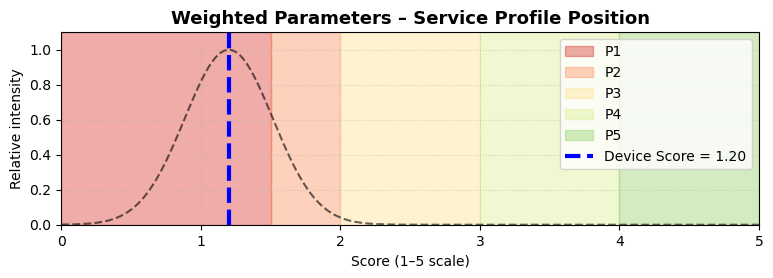

In [12]:
example = profile_service(
        reachability_score=2.0,
        operational_availability_score=1.0,
        privilege_threshold_score=1.0,
        interaction_dependency_score=1.0,
        exposure_weights=exposure_w,
        business_criticality=1,   # Mission-Critical (per doc)
        data_classification=1,    # Highly Restricted (per doc)
        formula_weights=formula_w,
        apply_guardrails=True,
    )
score_to_visualize = example["weighted"]["score"]
visualize_profile_position(score_to_visualize, title="Weighted Parameters – Service Profile Position")